# HW4 Template

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/alexmccall/opt/anaconda3/envs/mfe-preprogram4/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [3]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [4]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-18'
connection_string = 'sqlite:///data/data.db'
events_db = 'crypto_events_database'

In [5]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

calculate hourly return and hourly volume

In [6]:
prices['return'] = (prices['close'] - prices['close'].shift()) / prices['close']
prices['volatility'] = vol_ohlc(prices)

calculate max drawdown

In [7]:
window = prices.shape[0]
rolmax = prices['close'].rolling(window, min_periods=1).max()
ddrawdown = (prices['close']-rolmax)/rolmax
prices['maxdrawdown'] = ddrawdown.rolling(window, min_periods=1).min()
prices

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility,maxdrawdown
ts,,,,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC,NaN,NaN,0.000000
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC,-0.008597,NaN,-0.008524
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC,0.014557,NaN,-0.008524
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC,-0.002305,NaN,-0.008524
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC,0.009133,NaN,-0.008524
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17 19:00:00,60251.15,60666.69,60230.06,60495.82,1041.299769,6.297285e+07,BTC,BTC,0.004088,0.143008,-0.141402
2021-11-17 20:00:00,60495.83,60685.10,60118.08,60247.65,737.686854,4.453081e+07,BTC,BTC,-0.004119,0.142461,-0.141402
2021-11-17 21:00:00,60247.65,60600.00,60051.44,60436.83,782.694212,4.720895e+07,BTC,BTC,0.003130,0.097552,-0.141402


plot data

In [8]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

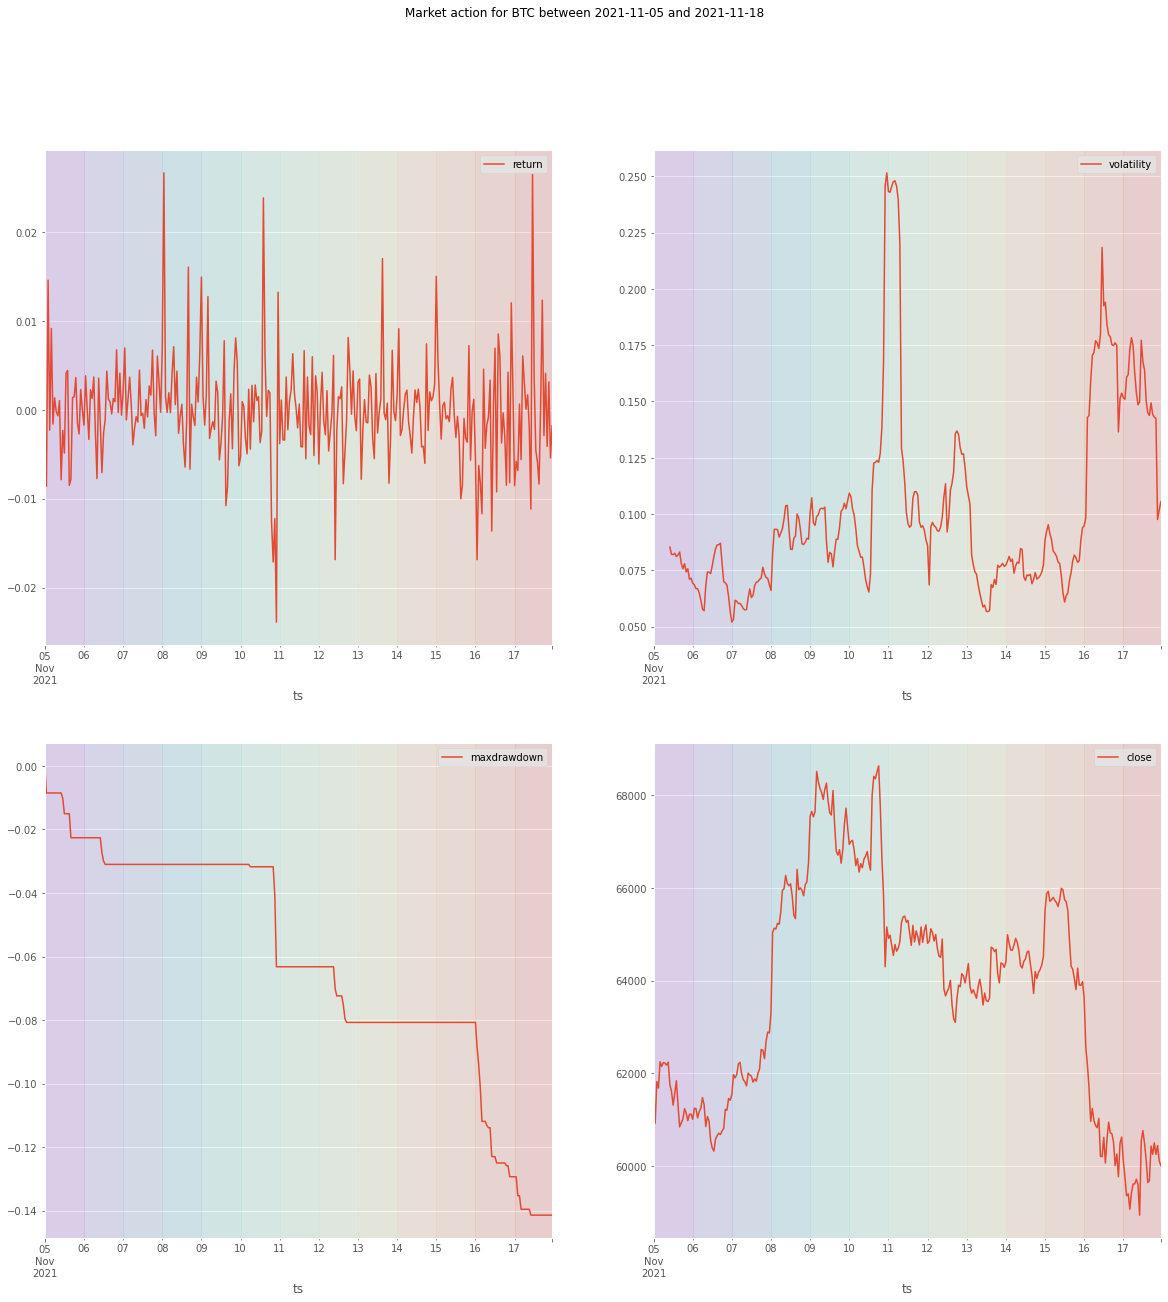

In [9]:
series_plot(prices[['return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['maxdrawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
# series_plot(pd.Series(prices['high'] - prices['low'], name='spread').to_frame(), ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

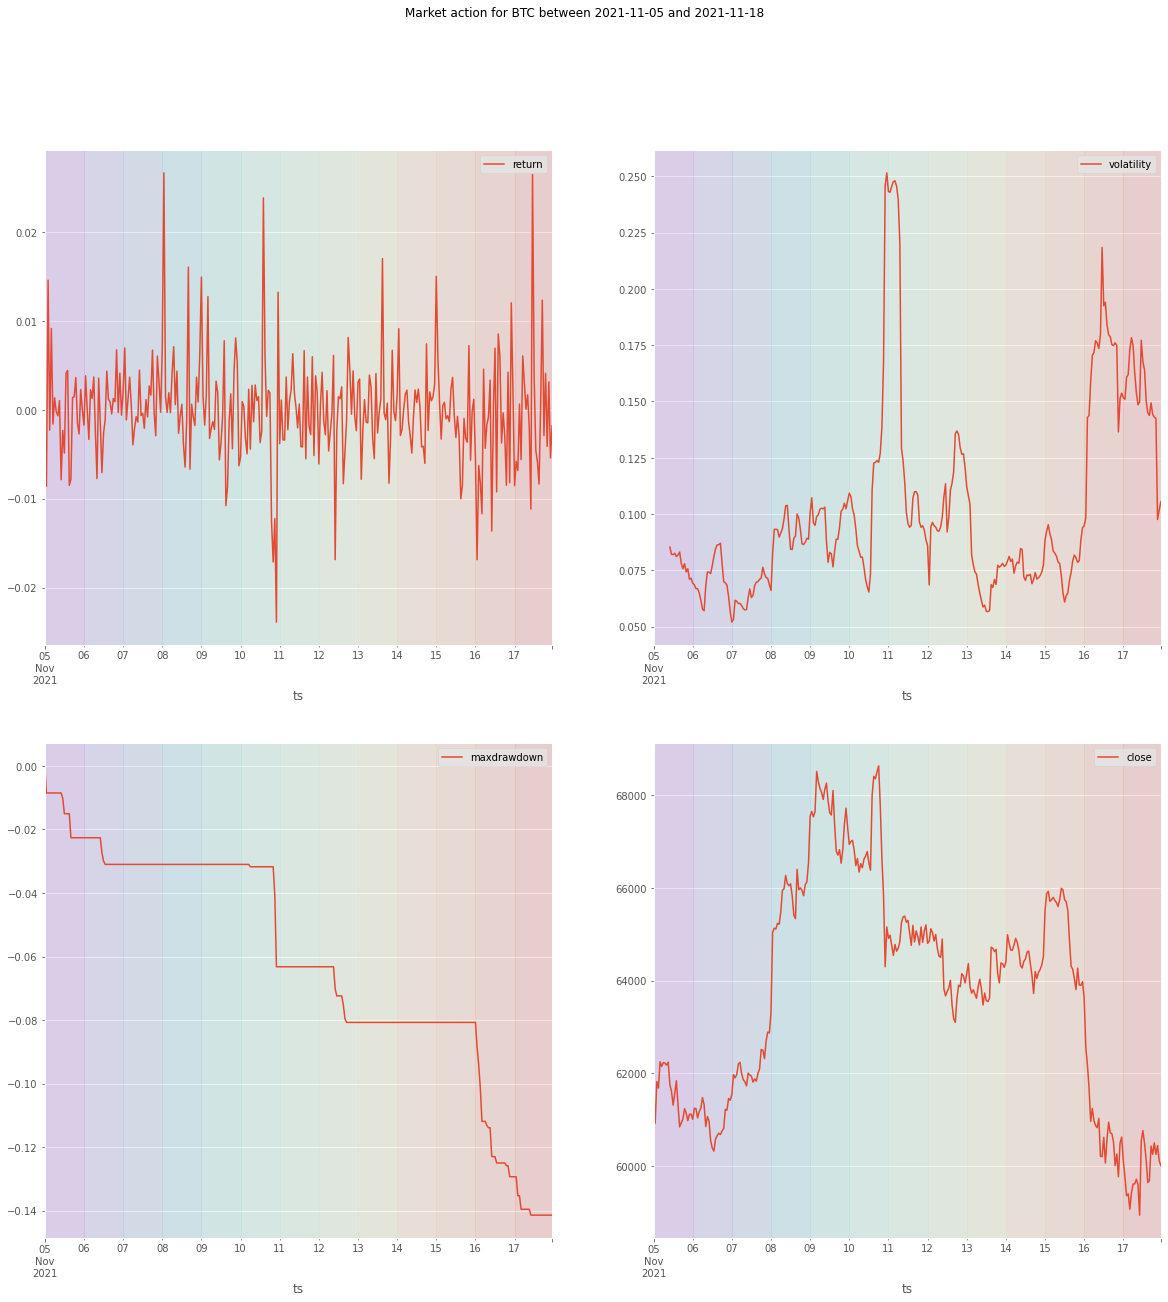

In [10]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)